Generate plots

In [1]:
import numpy as np
import pandas as pd
import pickle
import joypy
from pathlib import Path

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
results_folder = project_folder_path + 'results\\synthetic\\results\\bin_size_runs\\'
fig_folder = project_folder_path + 'results\\synthetic\\figures\\'

In [3]:
save_fig = False

### Load summary dataframes

ACF, iSTTC, PersonR, iSTTC trails (сoncat)

ACF vs iSTTC, full signal

PearsonR vs iSTTC (concat and avg), trails

In [22]:
def long_to_wide(df, spec, index_cols=None, value_col="tau_diff_rel"):
    """
    Convert a long tau df to wide.

    spec: dict {new_column_name -> method_name_in_df}
          e.g. {"tau_diff_rel_acf": "acf_full", "tau_diff_rel_isttc": "isttc_full"}
    index_cols: columns that identify a unit 
    value_col: the value column to pivot (default: "tau_diff_rel")
    """
    if index_cols is None:
        index_cols = ["unit_id", "fr", "alpha", "lv", "tau_ms_true"]
    methods = list(spec.values())
    tmp = df.loc[df["method"].isin(methods),
                 index_cols + ["method", value_col]]
    wide = tmp.pivot(index=index_cols, columns="method", values=value_col)
    wide = wide.rename(columns={m: new for new, m in spec.items()})
    return wide.reset_index()

def inspect(df, name):
    print(f"len {name}: {len(df)}")
    print(df.columns.tolist())

results_folder = Path(results_folder)

# From summary_tau_full_long_acf_lags_df
print('ACF, iSTTC, PersonR, iSTTC trails (сoncat)')
df_all = pd.read_pickle(results_folder / "summary_tau_full_long_acf_lags_df.pkl")
inspect(df_all, "df_all (all)")

ACF, iSTTC, PersonR, iSTTC trails (сoncat)
len df_all (all): 393496
['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared', 'acf_decline', 'method', 'tau_ms', 'duration_s', 'fr', 'alpha', 'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'n_lags', 'lv']


### Prepare extra dataframes for plotting 

In [23]:
# extract the reference tau_ms for n_lags=20
ref = df_all[df_all['n_lags'] == 20][['unit_id', 'tau_ms']]
ref = ref.rename(columns={'tau_ms': 'tau_ms_ref'})

# merge reference back onto the full dataframe
merged = df_all.merge(ref, on='unit_id', how='left')

# compute the difference
merged['tau_ms_diff'] = merged['tau_ms'] - merged['tau_ms_ref']

merged['tau_ms_diff_log10'] = np.log10(np.abs(merged['tau_ms_diff']) + 1)
merged['tau_diff_rel_log10'] = np.log10(merged['tau_diff_rel'])

merged

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,duration_s,fr,...,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,n_lags,lv,tau_ms_ref,tau_ms_diff,tau_ms_diff_log10,tau_diff_rel_log10
0,0,2.217899,2.119224,2.316575,0.998369,True,acf_full,110.894975,600,7.741821,...,150.923515,40.028540,26.522401,0.197350,20,1.307775,110.894975,0.000000,0.000000,1.423613
1,1,2.568210,2.437150,2.699270,0.997899,True,acf_full,128.410512,600,4.394396,...,147.947233,19.536721,13.205195,0.262120,20,1.345006,128.410512,0.000000,0.000000,1.120745
2,2,5.227451,4.334421,6.120482,0.984960,True,acf_full,261.372568,600,8.587393,...,267.002290,5.629722,2.108492,1.786061,20,1.068416,261.372568,0.000000,0.000000,0.323972
3,3,3.950209,2.250084,5.650335,0.889719,True,acf_full,197.510466,600,6.976707,...,194.403797,3.106670,1.598050,3.400250,20,1.055631,197.510466,0.000000,0.000000,0.203590
4,4,3.717963,3.426456,4.009471,0.995737,True,acf_full,185.898174,600,0.950832,...,239.986489,54.088315,22.538067,0.583014,20,1.357205,185.898174,0.000000,0.000000,1.352917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393491,99995,4.786764,2.679129,6.894399,0.719619,False,acf_full,239.338209,600,2.672839,...,125.243251,114.094959,91.098688,4.215270,40,1.178739,111.382499,127.955710,2.110441,1.959512
393492,99996,3.604462,3.395854,3.813070,0.993040,True,acf_full,180.223098,600,5.754497,...,94.481295,85.741803,90.750030,0.417216,40,1.353800,87.281338,92.941760,1.972859,1.957847
393493,99997,6.608891,4.356089,8.861693,0.827926,False,acf_full,330.444547,600,5.604441,...,174.189672,156.254875,89.703869,4.505604,40,1.064661,149.742178,180.702369,2.259361,1.952811
393494,99998,3.324856,2.192051,4.457660,0.803874,True,acf_full,166.242784,600,1.219057,...,76.565797,89.676987,117.124082,2.265609,40,1.306500,100.591044,65.651740,1.823811,2.068646


### Plots

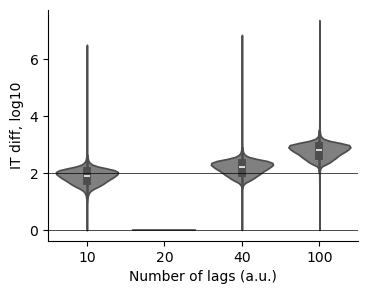

In [24]:
color = 'gray'

fig, axes = plt.subplots(1,1, figsize=(4,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

sns.violinplot(x='n_lags', y='tau_ms_diff_log10', data=merged , cut=0, density_norm='width', 
               legend=False, color=color, ax=axes)

axes.set_ylabel('IT diff, log10')
axes.set_xlabel('Number of lags (a.u.)')

axes.axhline(y=2, lw=0.5, c='k')
axes.axhline(y=0, lw=0.5, c='k')

#axes.set_xticklabels(['10', '20\n(reference)', '100'])

sns.despine()

# if save_fig:
#     plt.savefig(fig_folder + 'isttc_concat_zeros.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + 'isttc_concat_zeros.svg' , bbox_inches='tight')

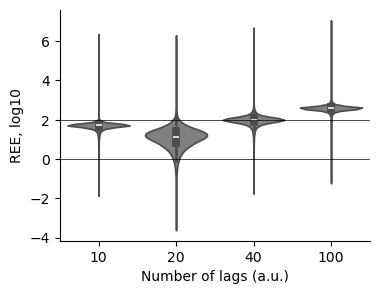

In [25]:
color = 'gray'

fig, axes = plt.subplots(1,1, figsize=(4,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

sns.violinplot(x='n_lags', y='tau_diff_rel_log10', data=merged , cut=0, density_norm='width', 
               legend=False, color=color, ax=axes)

axes.axhline(y=2, lw=0.5, c='k')
axes.axhline(y=0, lw=0.5, c='k')

axes.set_ylabel('REE, log10')
axes.set_xlabel('Number of lags (a.u.)')

sns.despine()